In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from collections import Counter
import gc
from datetime import datetime
import pickle

import optuna
from xgboost import XGBClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss, accuracy_score, precision_recall_curve, auc, roc_curve, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from tqdm import tqdm


In [52]:
def save_obj(filepath, obj):
    with open(filepath,"wb") as file:
        pickle.dump(file=file,obj=obj)
        
def load_obj(filepath):
    with open(filepath,"rb") as file:
        obj = pickle.load(file)
    return obj

In [3]:
df = pd.read_csv("/kaggle/input/train2/df_after_vector.csv")

In [11]:
df.head()

,q1_feats_m,q2_feats_m
0,[ -10.51348627 56.72666168 -240.25458837 -1...,[-7.08251953e-01 6.77137104e+01 -2.27965231e+...
1,[-1.55259051e+01 4.08530192e+01 8.10545866e+...,[-101.34449148 99.8820405 -23.97688222 -8...
2,[ -44.27294731 107.34632182 -140.8303628 6...,[ -23.75195074 18.89321685 -52.08408213 7...
3,[ 1.23025127e+02 7.23182192e+01 -9.81579103e+...,[-120.37668896 -36.89187908 -87.2084372 -2...
4,[ 11.9449712 -103.3166014 -202.35836136 3...,[ -3.1594367 13.73182952 -112.88908398 2...


In [4]:
gc.collect()

23

In [5]:
import re
pattern = '[\W]{2,5}'
df['q1_feats_m'] = df['q1_feats_m'].apply(lambda x: re.sub(pattern,' ',x.strip("[").strip("]").strip()))
df['q2_feats_m'] = df['q2_feats_m'].apply(lambda x: re.sub(pattern,' ',x.strip("[").strip("]").strip()))

In [27]:
gc.collect()

46

In [7]:
q1_df = df['q1_feats_m'].str.split(expand=True)
q2_df = df['q2_feats_m'].str.split(expand=True)

In [9]:
q1_df_arr = q1_df.apply(pd.to_numeric) 
q2_df_arr = q2_df.apply(pd.to_numeric) 

In [ ]:
import numpy as np
with open("q1.npy","wb") as array:
    np.save(array,q1_df_arr.values)
    
with open("q2.npy","wb") as array:
    np.save(array,q2_df_arr.values)

In [2]:
with open("/kaggle/input/arrays/q1.npy","rb") as array:
    q1 = np.load(array)
    
with open("/kaggle/input/arrays/q2.npy","rb") as array:
    q2 = np.load(array)

In [3]:
def similarity_distance_calculate(q1,q2):
    cosine_sim=[]
    euclidean_dist=[]
    for idx in tqdm(range(len(q1))):
        cosine_sim.append(cosine_similarity([q1[idx]],[q2[idx]]))
        euclidean_dist.append(euclidean_distances([q1[idx]],[q2[idx]]))
        
    return cosine_sim, euclidean_dist 
        

In [4]:
cosine_sim, euclidean_dist=similarity_distance_calculate(q1,q2)

100%|██████████| 404290/404290 [02:12<00:00, 3055.60it/s]


In [5]:
dist_df = pd.DataFrame({
    "cosine_sim":np.array(cosine_sim).flatten(),
    "euclidean_dist":np.array(euclidean_dist).flatten()})

In [56]:
dist_df.head(10)

,cosine_sim,euclidean_dist
0,0.986409,416.551078
1,0.752341,1107.084449
2,0.873861,1002.674451
3,0.667333,1173.279408
4,0.788618,1917.669434
5,0.839031,1211.664433
6,0.642460,1504.404869
7,0.926516,453.954048
8,0.991396,147.005335
9,0.762019,651.263204


In [6]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
dist_df["euclidean_dist"] = min_max.fit_transform(dist_df[["euclidean_dist"]])


In [22]:
save_obj("min_max.pkl",min_max)

In [10]:
dist_df.head(10)

,cosine_sim,euclidean_dist
0,0.986409,0.012585
1,0.752341,0.033448
2,0.873861,0.030294
3,0.667333,0.035448
4,0.788618,0.057939
5,0.839031,0.036608
6,0.642460,0.045453
7,0.926516,0.013715
8,0.991396,0.004441
9,0.762019,0.019677


In [23]:
c=0
for i in range(300):
        c+= A[i]*B[i]
cosine = c / float((sum(A)*sum(B))**0.5)
print("similarity: ", cosine)

similarity:  97.79532176179303


In [37]:
euclidean_distances([A],[B])

array([[299.9064673]])

In [31]:
cosine_similarity([A],[B])

array([[0.97756425]])

In [35]:
c=0
for i in range(300):
        c+= (A[i]-B[i])**2
euc = c**0.5
print("euclidean distance: ", euc)

euclidean distance:  299.90646730009587


In [12]:
final_data = pd.read_parquet("/kaggle/input/train-final/final_features.parquet")

In [16]:
final_data = final_data.drop(columns=['freq_qid1','freq_qid2','freq_q1+q2','freq_q1-q2'])

In [18]:
dist_df["id"] = final_data["id"]
result  = final_data.merge(dist_df, on='id',how='left')

In [19]:
result.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y,cosine_sim,euclidean_dist
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,93.558436,82.457197,17.701677,16.892752,18.082342,115.977202,107.869210,76.757549,0.986409,0.012585
1,1,0,0.799984,0.444440,0.599988,0.599988,0.699993,0.466664,0.0,1.0,...,82.440207,4.892528,155.426500,99.566298,77.538997,66.205757,108.603860,162.959745,0.752341,0.033448
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,118.439353,114.361097,41.180234,138.513988,145.557087,221.677197,3.016149,229.145969,0.873861,0.030294
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,21.755756,28.060877,35.912469,18.611610,77.108740,150.612036,32.371204,2.647544,0.667333,0.035448
4,4,0,0.499988,0.199998,0.666644,0.666644,0.571420,0.307690,0.0,1.0,...,117.491438,65.466095,145.510048,65.296788,8.415168,30.952414,23.655576,4.182842,0.788618,0.057939


In [20]:
result.to_parquet("final_data_with_sim.parquet")

In [21]:
del final_data
del q1
del q2
del dist_df
del euclidean_dist
del cosine_sim
del min_max
gc.collect()

12724

In [4]:
result= pd.read_parquet("/kaggle/working/final_data_with_sim.parquet")

In [5]:
y_true = result['is_duplicate']
result.drop(['id','is_duplicate'], axis=1, inplace=True)

In [6]:
y_true = list(map(int, y_true.values))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(result,y_true, stratify=y_true, test_size=0.20)

In [8]:
del result
gc.collect()

951

In [59]:
# For Ploting confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = ((C.T)/(C.sum(axis=1))).T  # divide each element of confusion matrix with sum of elements in that column
    B = C/C.sum(axis=0) # divide each element of confusion matrix with sum of elements in that row
    
    plt.figure(figsize=(10,2))
    labels = [1,2]
    cmap = sns.light_palette("pink")
    
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 7})
    plt.xlabel("Predicted Class",fontsize=5)
    plt.ylabel("Original Class",fontsize=5)
    plt.title("Confusion Matrix",fontsize=10)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 7})
    plt.xlabel('Predicted Class',fontsize=5)
    plt.ylabel('Original Class',fontsize=5)
    plt.title("Precision matrix",fontsize=10)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 7})
    plt.xlabel('Predicted Class',fontsize=5)
    plt.ylabel('Original Class',fontsize=5)
    plt.title("Recall matrix",fontsize=10)
    
    plt.show()

In [55]:
def prediction_evaluation(model, model_name, X_train, y_train, X_test, y_test):
    print(f"\n{'-'*15} {model_name} Performance {'-'*15}")
    predict_y  = model.predict_proba(X_train)
    log_loss_error = log_loss(y_train, predict_y, labels=[0,1], eps=1e-15)
    print(f"{model_name} --> Train --> Log-Loss = {round(log_loss_error,4)}")
    train_roc= roc_auc_score(y_train, predict_y[:,1], labels=[0,1])
    print(f"{model_name} --> Train --> ROC-AUC Score = {round(train_roc,4)}")

    predict_y  = model.predict_proba(X_test)
    log_loss_error = log_loss(y_test, predict_y, labels=[0,1], eps=1e-15)
    print(f"{model_name} --> Test --> Log-Loss = {round(log_loss_error,4)}")
    test_roc= roc_auc_score(y_test, predict_y[:,1], labels=[0,1])
    print(f"{model_name} --> Test --> ROC-AUC Score = {round(test_roc,4)}\n\n")

    plot_confusion_matrix(y_test, np.argmax(predict_y,axis=1))

Training Time = 0:00:35.290909
Performance Calculation in progress.........

--------------- Logistic Performance ---------------
Logistic --> Train --> Log-Loss = 0.5329
Logistic --> Train --> ROC-AUC Score = 0.7848
Logistic --> Test --> Log-Loss = 0.538
Logistic --> Test --> ROC-AUC Score = 0.7795


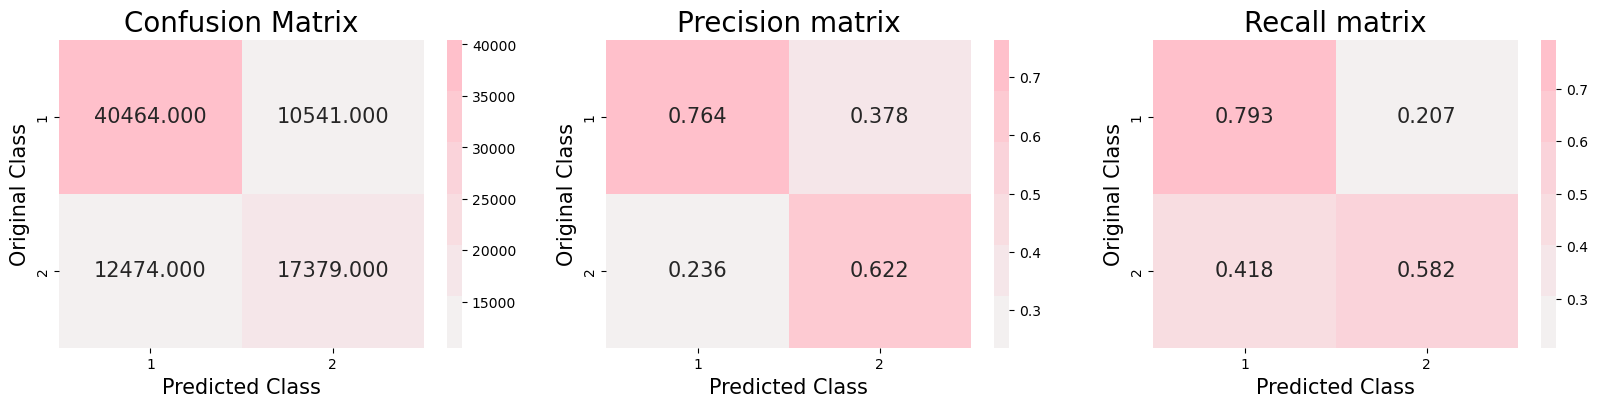

In [12]:
start = datetime.now()
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
print(f"Training Time = {datetime.now()-start}")

print("Performance Calculation in progress.........")
prediction_evaluation(logistic,"Logistic",X_train, y_train, X_test, y_test)

Training Time = 0:02:27.489619
Performance Calculation in progress..........

--------------- Logistic Sig Calibrated Performance ---------------
Logistic Sig Calibrated --> Train --> Log-Loss = 0.5328
Logistic Sig Calibrated --> Train --> ROC-AUC Score = 0.7848
Logistic Sig Calibrated --> Test --> Log-Loss = 0.5376
Logistic Sig Calibrated --> Test --> ROC-AUC Score = 0.7794


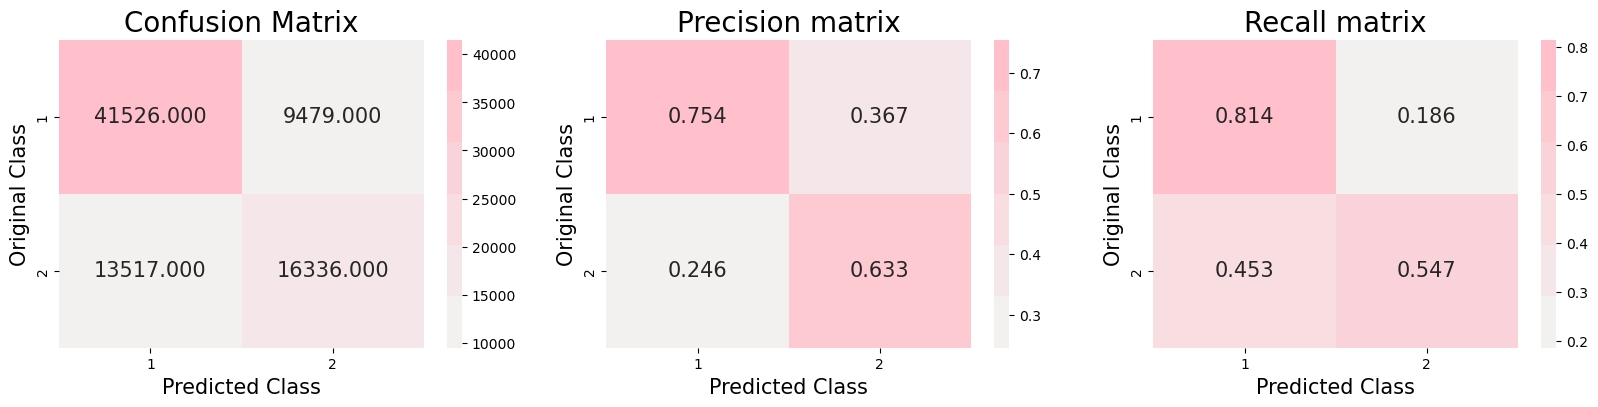

In [13]:
start = datetime.now()
sig_clf_log = CalibratedClassifierCV(logistic, method="sigmoid")
sig_clf_log.fit(X_train, y_train)
print(f"Training Time = {datetime.now()-start}")

print("Performance Calculation in progress..........")
prediction_evaluation(sig_clf_log,"Logistic Sig Calibrated",X_train, y_train, X_test, y_test)

In [14]:
del logistic
del sig_clf_log
gc.collect()

30186

In [41]:
def get_best_params_Grid(params, model, X_train, y_train):
    grid_model = GridSearchCV(estimator= model,
                              param_grid=params)
                              #scoring="neg_log_loss")
    grid_model.fit(X_train, y_train)
    pr = grid_model.best_params_
    return pr

In [44]:
def objective(trial,data = X_train, target = y_train):
    param = {
        'reg_lambda' : trial.suggest_loguniform('lambda', 1e-4, 10.0),
        'reg_alpha' :  trial.suggest_loguniform('alpha', 1e-4, 10.0),
        'booster' : trial.suggest_categorical('booster',['gbtree','dart']),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'subsample' : trial.suggest_categorical('subsample', [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'learning_rate' : trial.suggest_categorical('learning_rate',[.00001,.0003,.008,.02,.01,1,10,20]),
        'n_estimators' : trial.suggest_categorical('n_estimator',[200,300,400,500]),
        'max_depth' : trial.suggest_categorical('max_depth', [3,4,5,6,7,8,9,10,11,12]),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,200),
    }
    xgb_reg_model = XGBClassifier(objective="binary:logistic",
                              tree_method = 'gpu_hist',
                              early_stopping_rounds=20,
                              verbosity = 2, 
                              eval_metric='logloss', 
                              random_state=30,
                              **param)
    xgb_reg_model.fit(X_train,y_train, eval_set = [(X_test,y_test)], verbose = 2)
    pred_xgb = xgb_reg_model.predict_proba(X_test)
    logloss = log_loss(y_test, pred_xgb, labels=[0,1], eps=1e-15)
    return logloss

In [45]:
start = datetime.now()
find_param = optuna.create_study(study_name="xgboost_exp_5",direction='minimize')
find_param.optimize(objective, n_trials = 10)
params4 = find_param.best_params
print(params4)
print("Training Time = {}".format(datetime.now()-start))

[I 2023-03-07 12:51:41,445] A new study created in memory with name: xgboost_exp_5


[0]	validation_0-logloss:0.50596
[2]	validation_0-logloss:0.47938
[4]	validation_0-logloss:0.49308
[6]	validation_0-logloss:0.51602
[8]	validation_0-logloss:0.52946
[10]	validation_0-logloss:0.56128
[12]	validation_0-logloss:0.59495
[14]	validation_0-logloss:0.63042
[16]	validation_0-logloss:0.68265
[18]	validation_0-logloss:0.71830
[20]	validation_0-logloss:0.76141
[21]	validation_0-logloss:0.77475


[I 2023-03-07 12:51:53,739] Trial 0 finished with value: 0.4793766317308933 and parameters: {'lambda': 0.008295376429032754, 'alpha': 0.47413486555144085, 'booster': 'gbtree', 'colsample_bytree': 0.7, 'subsample': 0.1, 'learning_rate': 1, 'n_estimator': 300, 'max_depth': 8, 'min_child_weight': 17}. Best is trial 0 with value: 0.4793766317308933.


[12:52:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:3.19116
[12:52:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:14.99159
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:14.99159
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:14.99159
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:14.99159
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:14.99159
[12:52:04] INFO: ../src/gbm/gbtree.cc:909: drop 

[I 2023-03-07 12:52:05,372] Trial 1 finished with value: 3.1254295215625114 and parameters: {'lambda': 0.001702493947942793, 'alpha': 0.5197671907681708, 'booster': 'dart', 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 20, 'n_estimator': 400, 'max_depth': 12, 'min_child_weight': 83}. Best is trial 0 with value: 0.4793766317308933.


[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:3.25378
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:22.06641
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:22.06641
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:22.06641
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:22.06641
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:52:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:22.06641
[12:52:16] INFO: ../src/gbm/gbtree.cc:909: drop 

[I 2023-03-07 12:52:17,369] Trial 2 finished with value: 3.1792487573939994 and parameters: {'lambda': 0.0005578202344117636, 'alpha': 1.6580515548265817, 'booster': 'dart', 'colsample_bytree': 1, 'subsample': 0.1, 'learning_rate': 20, 'n_estimator': 300, 'max_depth': 12, 'min_child_weight': 85}. Best is trial 0 with value: 0.4793766317308933.


[0]	validation_0-logloss:0.68618
[2]	validation_0-logloss:0.67299
[4]	validation_0-logloss:0.66069
[6]	validation_0-logloss:0.64929
[8]	validation_0-logloss:0.63886
[10]	validation_0-logloss:0.62856
[12]	validation_0-logloss:0.61895
[14]	validation_0-logloss:0.60983
[16]	validation_0-logloss:0.60136
[18]	validation_0-logloss:0.59345
[20]	validation_0-logloss:0.58585
[22]	validation_0-logloss:0.57859
[24]	validation_0-logloss:0.57196
[26]	validation_0-logloss:0.56577
[28]	validation_0-logloss:0.55985
[30]	validation_0-logloss:0.55427
[32]	validation_0-logloss:0.54875
[34]	validation_0-logloss:0.54321
[36]	validation_0-logloss:0.53813
[38]	validation_0-logloss:0.53349
[40]	validation_0-logloss:0.52901
[42]	validation_0-logloss:0.52465
[44]	validation_0-logloss:0.52073
[46]	validation_0-logloss:0.51669
[48]	validation_0-logloss:0.51281
[50]	validation_0-logloss:0.50920
[52]	validation_0-logloss:0.50594
[54]	validation_0-logloss:0.50292
[56]	validation_0-logloss:0.49976
[58]	validation_0-l

[I 2023-03-07 12:52:52,917] Trial 3 finished with value: 0.3974470430692003 and parameters: {'lambda': 0.00038620619673447815, 'alpha': 0.029553415092583815, 'booster': 'gbtree', 'colsample_bytree': 0.6, 'subsample': 0.3, 'learning_rate': 0.02, 'n_estimator': 400, 'max_depth': 11, 'min_child_weight': 127}. Best is trial 3 with value: 0.3974470430692003.


[12:53:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69024
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.68456
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:0.67905
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:0.67371
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:0.66852
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:0.66348
[12:53:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 tre

[I 2023-03-07 12:55:51,738] Trial 4 finished with value: 0.4706641447744714 and parameters: {'lambda': 0.0005007562629082954, 'alpha': 0.45292342529129176, 'booster': 'dart', 'colsample_bytree': 1, 'subsample': 0.9, 'learning_rate': 0.008, 'n_estimator': 200, 'max_depth': 8, 'min_child_weight': 124}. Best is trial 3 with value: 0.3974470430692003.


[12:56:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69032
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.68475
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:0.67930
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:0.67418
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:0.66923
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[12:56:02] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:0.66424
[12:56:03] INFO: ../src/gbm/gbtree.cc:909: drop 0 tre

[I 2023-03-07 13:02:28,639] Trial 5 finished with value: 0.42993903843366105 and parameters: {'lambda': 0.1960272974164525, 'alpha': 0.22204235166994368, 'booster': 'dart', 'colsample_bytree': 0.7, 'subsample': 0.2, 'learning_rate': 0.008, 'n_estimator': 400, 'max_depth': 8, 'min_child_weight': 31}. Best is trial 3 with value: 0.3974470430692003.


[0]	validation_0-logloss:0.68623
[2]	validation_0-logloss:0.67393
[4]	validation_0-logloss:0.66241
[6]	validation_0-logloss:0.65127
[8]	validation_0-logloss:0.64200
[10]	validation_0-logloss:0.63177
[12]	validation_0-logloss:0.62214
[14]	validation_0-logloss:0.61323
[16]	validation_0-logloss:0.60487
[18]	validation_0-logloss:0.59709
[20]	validation_0-logloss:0.58970
[22]	validation_0-logloss:0.58264
[24]	validation_0-logloss:0.57622
[26]	validation_0-logloss:0.57048
[28]	validation_0-logloss:0.56488
[30]	validation_0-logloss:0.55928
[32]	validation_0-logloss:0.55407
[34]	validation_0-logloss:0.54847
[36]	validation_0-logloss:0.54341
[38]	validation_0-logloss:0.53877
[40]	validation_0-logloss:0.53430
[42]	validation_0-logloss:0.52992
[44]	validation_0-logloss:0.52596
[46]	validation_0-logloss:0.52201
[48]	validation_0-logloss:0.51839
[50]	validation_0-logloss:0.51480
[52]	validation_0-logloss:0.51153
[54]	validation_0-logloss:0.50849
[56]	validation_0-logloss:0.50527
[58]	validation_0-l

[I 2023-03-07 13:03:01,510] Trial 6 finished with value: 0.39545242751438453 and parameters: {'lambda': 0.006036117362196125, 'alpha': 0.001916538681645691, 'booster': 'gbtree', 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.02, 'n_estimator': 500, 'max_depth': 7, 'min_child_weight': 127}. Best is trial 6 with value: 0.39545242751438453.


[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:2.77373
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:23.23943
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:23.23943
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:23.23943
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:23.23943
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:23.23943
[13:03:11] INFO: ../src/gbm/gbtree.cc:909: drop 

[I 2023-03-07 13:03:13,095] Trial 7 finished with value: 2.7405858405180243 and parameters: {'lambda': 0.0006218694255496268, 'alpha': 0.0015539319135827265, 'booster': 'dart', 'colsample_bytree': 0.2, 'subsample': 0.5, 'learning_rate': 20, 'n_estimator': 400, 'max_depth': 7, 'min_child_weight': 113}. Best is trial 6 with value: 0.39545242751438453.


[13:03:22] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:1.30131
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:20.13914
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:14.85021
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:14.85021
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:14.85021
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:14.85021
[13:03:23] INFO: ../src/gbm/gbtree.cc:909: drop 

[I 2023-03-07 13:03:24,648] Trial 8 finished with value: 1.3013062903851054 and parameters: {'lambda': 0.8465664740292644, 'alpha': 0.13353754852231503, 'booster': 'dart', 'colsample_bytree': 0.1, 'subsample': 0.9, 'learning_rate': 10, 'n_estimator': 400, 'max_depth': 5, 'min_child_weight': 132}. Best is trial 6 with value: 0.39545242751438453.


[0]	validation_0-logloss:0.69304
[2]	validation_0-logloss:0.69282
[4]	validation_0-logloss:0.69260
[6]	validation_0-logloss:0.69238
[8]	validation_0-logloss:0.69217
[10]	validation_0-logloss:0.69195
[12]	validation_0-logloss:0.69174
[14]	validation_0-logloss:0.69152
[16]	validation_0-logloss:0.69130
[18]	validation_0-logloss:0.69108
[20]	validation_0-logloss:0.69087
[22]	validation_0-logloss:0.69065
[24]	validation_0-logloss:0.69044
[26]	validation_0-logloss:0.69022
[28]	validation_0-logloss:0.69001
[30]	validation_0-logloss:0.68979
[32]	validation_0-logloss:0.68958
[34]	validation_0-logloss:0.68936
[36]	validation_0-logloss:0.68915
[38]	validation_0-logloss:0.68893
[40]	validation_0-logloss:0.68872
[42]	validation_0-logloss:0.68851
[44]	validation_0-logloss:0.68829
[46]	validation_0-logloss:0.68808
[48]	validation_0-logloss:0.68787
[50]	validation_0-logloss:0.68766
[52]	validation_0-logloss:0.68745
[54]	validation_0-logloss:0.68723
[56]	validation_0-logloss:0.68702
[58]	validation_0-l

[I 2023-03-07 13:04:05,380] Trial 9 finished with value: 0.6538929859687078 and parameters: {'lambda': 0.2666229898705664, 'alpha': 0.00022201232043590765, 'booster': 'gbtree', 'colsample_bytree': 0.9, 'subsample': 1, 'learning_rate': 0.0003, 'n_estimator': 400, 'max_depth': 8, 'min_child_weight': 109}. Best is trial 6 with value: 0.39545242751438453.


{'lambda': 0.006036117362196125, 'alpha': 0.001916538681645691, 'booster': 'gbtree', 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.02, 'n_estimator': 500, 'max_depth': 7, 'min_child_weight': 127}
Training Time = 0:12:23.937651


In [46]:
params = {'n_estimators': 400,    ### 100
          'reg_lambda': 0.47178174724444527, 
          'reg_alpha': 0.008450456795608624, 
          'colsample_bytree': 0.7, 
          'subsample': 0.3, 
          'learning_rate': 0.01, 
          'max_depth': 12, 
          'min_child_weight': 74}

params3= {'reg_lambda': 0.0016711225229536217, 
          'reg_alpha': 0.7332325914607827, 
          'booster': 'dart', 
          'colsample_bytree': 0.5, 
          'subsample': 0.5, 
          'learning_rate': 0.01, 
          'n_estimators': 500, #400
          'max_depth': 11, 
          'min_child_weight': 85}

params4 =   {'lambda': 0.00015027928492833143,
             'alpha': 0.003431271715532022,
             'booster': 'dart',
             'colsample_bytree': 1,
             'subsample': 0.9,
             'learning_rate': 1,
             'n_estimators': 500,
             'max_depth': 5,
             'min_child_weight': 67}

params5 = {'lambda': 0.006036117362196125, 
           'alpha': 0.001916538681645691, 
           'booster': 'gbtree', 
           'colsample_bytree': 0.5, 
           'subsample': 0.9, 
           'learning_rate': 0.02, 
           'n_estimators': 500, 
           'max_depth': 7, 
           'min_child_weight': 127}

In [47]:
start = datetime.now()
xgb_reg_model = XGBClassifier(objective="binary:logistic",
                              tree_method = 'gpu_hist',
                              verbosity = 2, 
                              eval_metric='logloss', 
                              random_state=30,
                              **params5)
xgb_reg_model.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 2)
print("Training Time ={}".format(datetime.now()-start))              

[0]	validation_0-logloss:0.68623
[2]	validation_0-logloss:0.67393
[4]	validation_0-logloss:0.66241
[6]	validation_0-logloss:0.65127
[8]	validation_0-logloss:0.64200
[10]	validation_0-logloss:0.63177
[12]	validation_0-logloss:0.62214
[14]	validation_0-logloss:0.61323
[16]	validation_0-logloss:0.60487
[18]	validation_0-logloss:0.59709
[20]	validation_0-logloss:0.58970
[22]	validation_0-logloss:0.58264
[24]	validation_0-logloss:0.57622
[26]	validation_0-logloss:0.57048
[28]	validation_0-logloss:0.56488
[30]	validation_0-logloss:0.55928
[32]	validation_0-logloss:0.55407
[34]	validation_0-logloss:0.54847
[36]	validation_0-logloss:0.54341
[38]	validation_0-logloss:0.53877
[40]	validation_0-logloss:0.53430
[42]	validation_0-logloss:0.52992
[44]	validation_0-logloss:0.52596
[46]	validation_0-logloss:0.52201
[48]	validation_0-logloss:0.51839
[50]	validation_0-logloss:0.51480
[52]	validation_0-logloss:0.51153
[54]	validation_0-logloss:0.50849
[56]	validation_0-logloss:0.50527
[58]	validation_0-l

In [54]:
start = datetime.now()
sig_clf_xgb = CalibratedClassifierCV(base_estimator=xgb_reg_model, 
                                     method="sigmoid")
sig_clf_xgb.fit(X_train, y_train)
print("Training Time =",datetime.now() - start )

Training Time = 0:02:16.470462


Performance Calculation in progress..........

--------------- XGBoost Performance ---------------
XGBoost --> Train --> Log-Loss = 0.3764
XGBoost --> Train --> ROC-AUC Score = 0.9078
XGBoost --> Test --> Log-Loss = 0.3955
XGBoost --> Test --> ROC-AUC Score = 0.8907


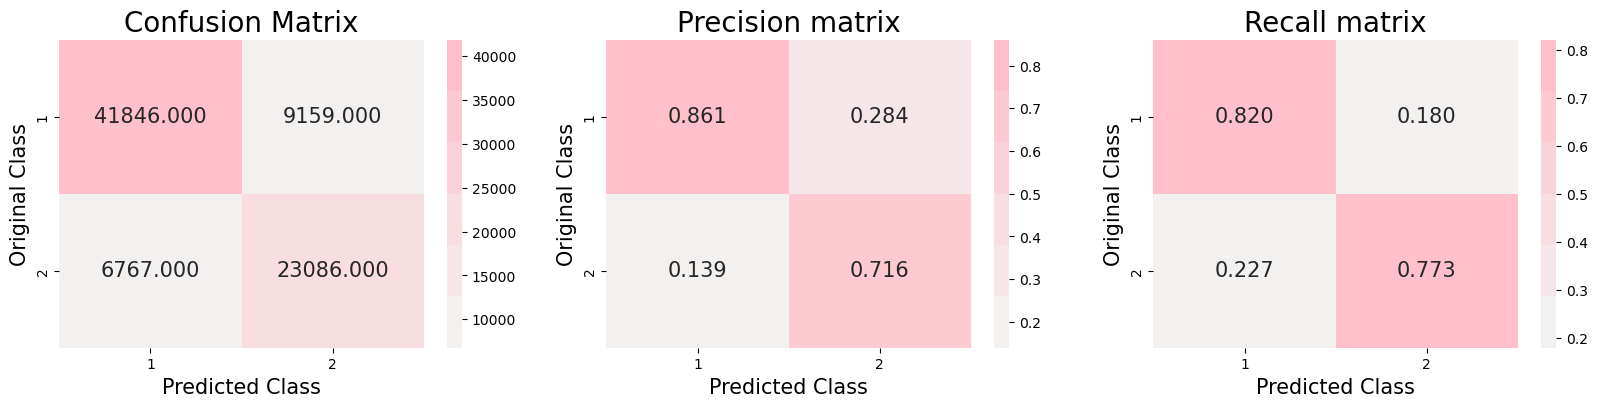

In [49]:
print("Performance Calculation in progress..........")
prediction_evaluation(xgb_reg_model,"XGBoost",X_train, y_train, X_test, y_test)

Performance Calculation in progress..........

--------------- XGBoost Calibrated Performance ---------------
XGBoost Calibrated --> Train --> Log-Loss = 0.3701
XGBoost Calibrated --> Train --> ROC-AUC Score = 0.9062
XGBoost Calibrated --> Test --> Log-Loss = 0.3968
XGBoost Calibrated --> Test --> ROC-AUC Score = 0.8901




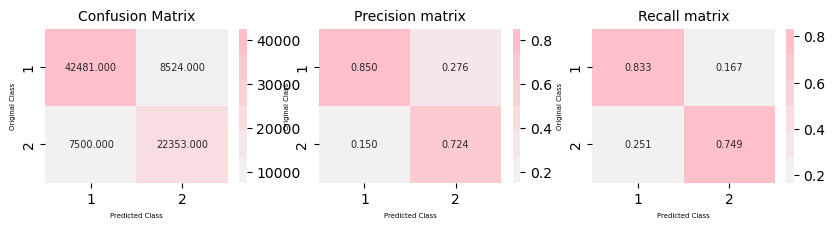

In [60]:
print("Performance Calculation in progress..........")
prediction_evaluation(sig_clf_xgb,"XGBoost Calibrated",X_train, y_train, X_test, y_test)

In [53]:
save_obj("xgboost5_calibrated.pickle", sig_clf_xgb)

In [23]:
xgb_reg_grid_model = XGBClassifier(objective="binary:logistic",
                              tree_method = 'gpu_hist',
                              verbosity = 1, 
                              eval_metric='logloss', 
                              random_state=30)

In [ ]:
start = datetime.now()
params = {
        'reg_lambda' : np.random.lognormal(1e-4,10.0,size=10),
        'reg_alpha' :  np.random.lognormal(1e-4,10.0,size=10),
        'booster' : ['gbtree','dart'],
        'colsample_bytree' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
        'subsample' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
        'learning_rate' : [.00001,.0003,.008,.02,.01,1,10,20],
        'n_estimators' : [200,300,400,500],
        'max_depth' : [3,4,5,6,7,8,9,10,11,12],
        'min_child_weight' : np.random.randint(1,200,size=10),
}
grid_params = get_best_params_Grid(xgb_reg_grid_model, params, X_train, y_train)
print(grid_params)
print("Training Time =",datetime.now() - start )